In [1]:
%load_ext autoreload
%autoreload 2

import sys
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import logging
import tfutils

tf.logging.set_verbosity(tf.logging.WARN)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# Plot evaluation results

INFO:root:Train file: /Users/guyg/Dropbox/machine-learning/large-n-hyperparams-experiments/tensorflow-experiments/regression/models/regression-relu-100-100-N=128-sigma=0.20-omega=3.0/events.out.tfevents.1517170068.mbp106.local
INFO:root:Validation file: /Users/guyg/Dropbox/machine-learning/large-n-hyperparams-experiments/tensorflow-experiments/regression/models/regression-relu-100-100-N=128-sigma=0.20-omega=3.0/eval/events.out.tfevents.1517170071.mbp106.local
INFO:root:Reading events file /Users/guyg/Dropbox/machine-learning/large-n-hyperparams-experiments/tensorflow-experiments/regression/models/regression-relu-100-100-N=128-sigma=0.20-omega=3.0/events.out.tfevents.1517170068.mbp106.local


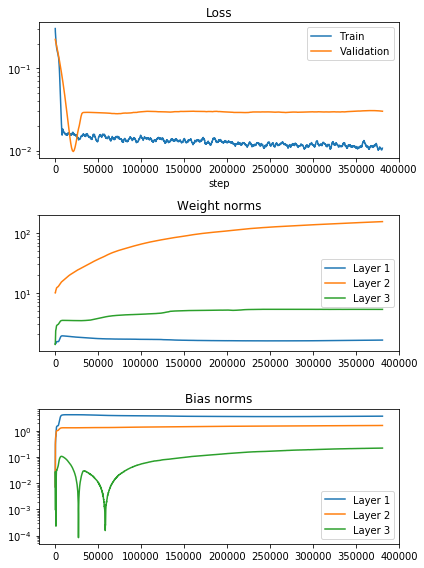

In [47]:
import tfutils
from deep_regression import *
import matplotlib.pyplot as plt

p = ExperimentParams(
    model_name = 'regression-relu',
    model_fn = create_model_fn(),
    widths = [100, 100],

    xmin = 0.,
    xmax = 2. * math.pi,
    
    noise_sigma = 0.2,
    omega = 3,
    learning_rate = 1e-3,

    n_train = 128,
    n_val = 128,
    epochs = 50000,
    batch_size = 32,
    save_checkpoint_steps=5000,
    save_summary_steps=2000,
    save_eval_plots_steps=2000,
)

try:
    new_train_events, new_val_events = tfutils.read_train_eval_events(get_model_dir(p))
    train_events = new_train_events
    val_events = new_val_events
except tf.errors.DataLossError:
    logging.warning('Failed to read new data, re-using old data')
    
train_loss = np.asarray(tfutils.get_events(train_events, 'train_loss'))
val_loss = np.asarray(tfutils.get_events(val_events, 'loss'))

smooth_train_loss = tfutils.smooth_data_series(train_loss)
smooth_val_loss = tfutils.smooth_data_series(val_loss)
#smooth_val_loss = val_loss

plt.figure(figsize=(6,8))
plt.clf()

plt.subplot(311)
plt.semilogy(train_loss[:, 0], smooth_train_loss[:, 1], '-', label='Train')
if val_loss is not None:
    plt.semilogy(val_loss[:, 0], smooth_val_loss[:, 1], '-', label='Validation')
plt.legend()
plt.title('Loss')
plt.xlabel('step')
plots_dir = '%s/plots' % get_model_dir(p)
if not os.path.exists(plots_dir):
    os.mkdir(plots_dir)

plt.subplot(312)
try:
    for k in range(1,10):
        w = np.asarray(tfutils.get_events(train_events, 'weights%d' % k))
        plt.semilogy(w[:, 0], w[:, 1], '-', label='Layer %d' % k)
except KeyError:
    pass
plt.legend()
plt.title('Weight norms')

plt.subplot(313)
try:
    for k in range(1,10):
        b = np.asarray(tfutils.get_events(train_events, 'biases%d' % k))
        plt.semilogy(b[:, 0], b[:, 1], '-', label='Layer %d' % k)        
except KeyError:
    pass
plt.legend()
plt.title('Bias norms')

plt.tight_layout()
plt.savefig('%s/losses.png' % plots_dir)
plt.show()


# Basic training

Basic training and evaluation example.

In [ ]:
from deep_regression import *

#delete_all_models()

p = ExperimentParams(
    model_name = 'regression-relu',
    model_fn = create_model_fn(),
    widths = [100, 100],

    xmin = 0.,
    xmax = 2. * math.pi,
    
    noise_sigma = 0.2,
    omega = 3,
    learning_rate = 1e-3,

    n_train = 64,
    n_val = 64,
    epochs = 50000,
    batch_size = 32,
    save_checkpoint_steps=2000,
)

target_fn = create_target_fn(p.noise_sigma, p.omega)
model = create_estimator(p)

# Train
#train_x, train_y = train(model, target_fn, p)
#test_input_fn, test_x, test_y = create_input_fn(
#    target_fn, p.xmin - 2*math.pi, p.xmax + 2*math.pi, 
#    p.n_val, epochs=1, batch_size=p.batch_size, shuffle=False)

train_x, train_y, test_x, test_y = train_and_eval(model, target_fn, p)
test_input_fn = create_input_fn_from_data(test_x, test_y, shuffle=False)

# Evaluate
train_input_fn = create_input_fn_from_data(train_x, train_y, shuffle=False)
train_pred = predict(model, train_input_fn)

test_pred = predict(model, test_input_fn)

plt.figure(1)
plt.clf()
plt.subplot(211)
plt.plot(train_x, train_y, '.', train_x, train_pred, '.')
plt.title('%s layers=%s N=%d epochs=%d' % (p.model_name, p.widths, p.n_train, p.epochs))

plt.subplot(212)
plt.plot(test_x, test_y, '.', test_x, test_pred, '.')
plt.ylim(-3,3)
plt.savefig('plot.png')
plt.show()

train_loss, val_loss = tfutils.read_loss_summaries(get_model_dir(p))
plt.figure(2)
plt.clf()
plt.semilogy(train_loss[:, 0], train_loss[:, 1], '.', label='Train')
if val_loss is not None:
    plt.semilogy(val_loss[:, 0], val_loss[:, 1], '+', label='Validation')
plt.legend()
plt.title('Losses')
plt.show()

INFO:root:loss = 0.5396735846942582, global_step = 1, epochs = 1
INFO:root:loss = 0.4238928283910285, global_step = 414, epochs = 207
INFO:root:loss = 0.4218713523760341, global_step = 727, epochs = 364
INFO:root:loss = 0.2819788448208763, global_step = 1293, epochs = 647
INFO:root:loss = 0.33704434508620207, global_step = 1649, epochs = 825
INFO:root:loss = 0.32884949374015415, global_step = 2150, epochs = 1075
INFO:root:loss = 0.3332431522747763, global_step = 2617, epochs = 1309
INFO:root:loss = 0.3927378395177805, global_step = 2879, epochs = 1440
INFO:root:loss = 0.2931116723430063, global_step = 3233, epochs = 1617
INFO:root:loss = 0.30285110939956167, global_step = 3623, epochs = 1812
INFO:root:loss = 0.2560409948179082, global_step = 3925, epochs = 1963
INFO:root:loss = 0.32419221854601377, global_step = 4026, epochs = 2013
INFO:root:loss = 0.41761865150648014, global_step = 4358, epochs = 2179
INFO:root:loss = 0.39242404358996574, global_step = 4460, epochs = 2230
INFO:root:lo

# Bias during training

TODO rewrite using ExperimentParams

Collect how biases evolve during training. Trying to understand the 'left-to-right' behavior.

In [ ]:
# Disable checkpoints
#config = tf.estimator.RunConfig(
#    save_checkpoints_steps=None,
#    save_checkpoints_secs=None,
#)

model_name = 'regression-relu'
model_fn = model_fn_relu
widths = [100, 100]

noise_sigma = 0.1
omega = 16
learning_rate = 1e-3

n_train = 2048
epochs = 20000
batch_size = 128

target_fn = create_target_fn(noise_sigma, omega)
model = create_estimator(model_fn, widths, n_train, learning_rate,
                         noise_sigma, model_name, omega)

xmin = 0.
xmax = 2. * math.pi

train_input_fn, train_x, train_y = create_input_fn(
    target_fn, xmin, xmax, n_train, epochs, batch_size)

logging_hook = logutils.MyLoggingTensorHook(
    tensors={'loss': 'loss'},
    every_n_secs=1,
    steps_per_epoch=steps_per_epoch(n_train, batch_size))

bias_hook = TensorHistoryHook('hidden1/bias:0', every_n_steps=n_train//batch_size)

model.train(train_input_fn,
            hooks=[bias_hook, logging_hook])

plt.plot(bias_hook.steps, bias_hook.values[:,0], '.')
plt.show()

20000


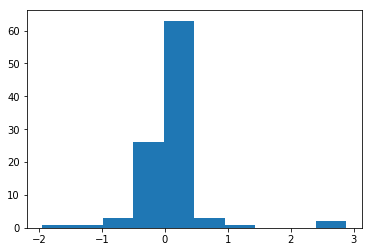

100


array([-1.95205029, -1.1394826 , -0.87487462, -0.90575127, -0.76722876,
       -0.50076599])

In [157]:
print(len(bias_hook.values))
plt.hist(bias_hook.values[19000,:])
plt.show()

vals = bias_hook.values[19000, :]
print(len(vals))
vals[vals < -0.5]

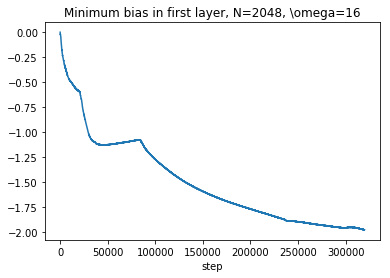

In [138]:
plt.plot(bias_hook.steps, bias_hook.values.min(axis=1))
#plt.hist(bias_hook.values[3000,:])
plt.xlabel('step')
plt.title('Minimum bias in first layer, N=2048, \omega=16')
plt.savefig('bias.png')
plt.show()

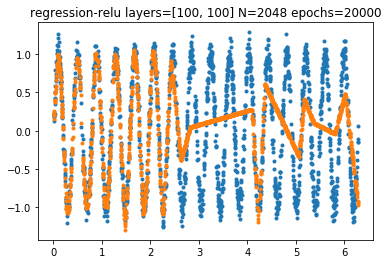

In [139]:
train_input_fn = create_input_fn_from_data(train_x, train_y, shuffle=False)
train_pred = predict(model, train_input_fn)

plt.figure(1)
plt.clf()
#plt.subplot(211)
plt.plot(train_x, train_y, '.', train_x, train_pred, '.')
plt.title('%s layers=%s N=%d epochs=%d' % (model_name, widths, n_train, epochs))
plt.savefig('plot.png')
plt.show()

# TODO

* Run deep regression with sin(\omega x) with different choices for \omega, see how convergence time changes with \omega.
    - With fixed, large n_train
    - With fixed n_train per period
* Linear regression: Do the shrunken weights fit all the training points? (How is this consistent with \theta* being small?)
* What constrains the relu network from overfitting?

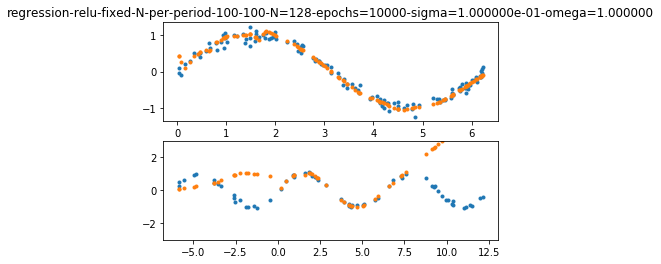

INFO:root:loss = 0.9676579060308153, global_step = 1, epochs = 1
INFO:root:loss = 0.3428778614734166, global_step = 387, epochs = 194 (1.068 sec)
INFO:root:loss = 0.08960696808787064, global_step = 908, epochs = 454 (1.003 sec)
INFO:root:loss = 0.06397697453631977, global_step = 1287, epochs = 644 (1.005 sec)
INFO:root:loss = 0.0783560224338775, global_step = 1810, epochs = 905 (1.004 sec)
INFO:root:loss = 0.08103452245325232, global_step = 2158, epochs = 1079 (1.002 sec)
INFO:root:loss = 0.07968035427924698, global_step = 2699, epochs = 1350 (1.002 sec)
INFO:root:loss = 0.06828438427116529, global_step = 3002, epochs = 1501 (1.008 sec)
INFO:root:loss = 0.0663094185671708, global_step = 3641, epochs = 1821 (1.002 sec)
INFO:root:loss = 0.06369617393799094, global_step = 4076, epochs = 2038 (1.003 sec)
INFO:root:loss = 0.10037523302770988, global_step = 4712, epochs = 2356 (1.003 sec)
INFO:root:loss = 0.06136043197259937, global_step = 5119, epochs = 2560 (1.003 sec)
INFO:root:loss = 0.0

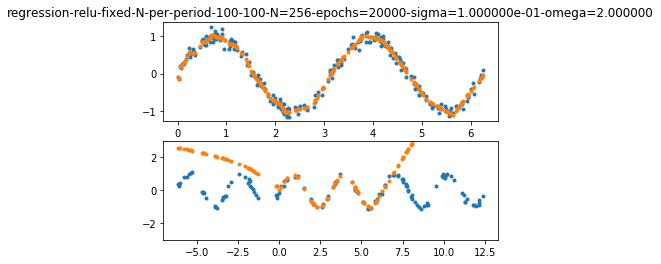

INFO:root:loss = 0.5868035059491562, global_step = 1, epochs = 1
INFO:root:loss = 0.3978027559233538, global_step = 451, epochs = 151 (1.055 sec)
INFO:root:loss = 0.26660298323680903, global_step = 891, epochs = 297 (1.004 sec)
INFO:root:loss = 0.2601418754769425, global_step = 1160, epochs = 387 (1.003 sec)
INFO:root:loss = 0.3145311073996787, global_step = 1600, epochs = 534 (1.007 sec)
INFO:root:loss = 0.2638002702389206, global_step = 1979, epochs = 660 (1.004 sec)
INFO:root:loss = 0.24683037836338215, global_step = 2256, epochs = 752 (1.002 sec)
INFO:root:loss = 0.18276832684307293, global_step = 2777, epochs = 926 (1.002 sec)
INFO:root:loss = 0.13453782843803141, global_step = 3120, epochs = 1040 (1.001 sec)
INFO:root:loss = 0.07676178085589906, global_step = 3625, epochs = 1209 (1.006 sec)
INFO:root:loss = 0.07615592668601656, global_step = 4002, epochs = 1334 (1.364 sec)
INFO:root:loss = 0.06567178128604617, global_step = 4406, epochs = 1469 (1.003 sec)
INFO:root:loss = 0.08218

INFO:root:loss = 0.00900538426332694, global_step = 44081, epochs = 14694 (1.003 sec)
INFO:root:loss = 0.008539033245714426, global_step = 44702, epochs = 14901 (1.003 sec)
INFO:root:loss = 0.009514827205125979, global_step = 45088, epochs = 15030 (1.004 sec)
INFO:root:loss = 0.008437874857042997, global_step = 45674, epochs = 15225 (1.002 sec)
INFO:root:loss = 0.00944448164274947, global_step = 46073, epochs = 15358 (1.002 sec)
INFO:root:loss = 0.00906157569459708, global_step = 46677, epochs = 15559 (1.003 sec)
INFO:root:loss = 0.010138896768123747, global_step = 47024, epochs = 15675 (1.003 sec)
INFO:root:loss = 0.00957868667280996, global_step = 47651, epochs = 15884 (1.003 sec)
INFO:root:loss = 0.008542139276408076, global_step = 48062, epochs = 16021 (1.003 sec)
INFO:root:loss = 0.009858747211109672, global_step = 48699, epochs = 16233 (1.002 sec)
INFO:root:loss = 0.008800760520573438, global_step = 49067, epochs = 16356 (1.002 sec)
INFO:root:loss = 0.00999525799161829, global_st

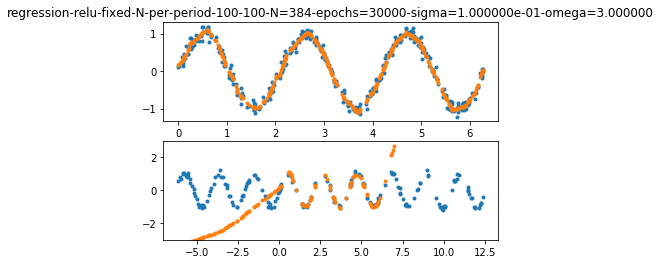

INFO:root:loss = 0.4917428438994163, global_step = 1, epochs = 1
INFO:root:loss = 0.44836146164109797, global_step = 416, epochs = 104 (1.040 sec)
INFO:root:loss = 0.39914354210025127, global_step = 959, epochs = 240 (1.002 sec)
INFO:root:loss = 0.3250979432604164, global_step = 1315, epochs = 329 (1.002 sec)
INFO:root:loss = 0.32348374773249067, global_step = 1930, epochs = 483 (1.004 sec)
INFO:root:loss = 0.34907294437355235, global_step = 2313, epochs = 579 (1.004 sec)
INFO:root:loss = 0.29259689951381573, global_step = 2927, epochs = 732 (1.002 sec)
INFO:root:loss = 0.2867045014051148, global_step = 3327, epochs = 832 (1.002 sec)
INFO:root:loss = 0.2477700617432455, global_step = 3942, epochs = 986 (1.003 sec)
INFO:root:loss = 0.2551339638565755, global_step = 4325, epochs = 1082 (1.003 sec)
INFO:root:loss = 0.22193979300421657, global_step = 4918, epochs = 1230 (1.003 sec)
INFO:root:loss = 0.19520031771019794, global_step = 5287, epochs = 1322 (1.002 sec)
INFO:root:loss = 0.215372

INFO:root:loss = 0.031259335527985266, global_step = 47002, epochs = 11751 (1.064 sec)
INFO:root:loss = 0.010791528031081968, global_step = 47452, epochs = 11863 (1.003 sec)
INFO:root:loss = 0.016647038035393615, global_step = 47868, epochs = 11967 (1.008 sec)
INFO:root:loss = 0.011741522137475192, global_step = 48024, epochs = 12006 (1.002 sec)
INFO:root:loss = 0.01135633457871655, global_step = 48585, epochs = 12147 (1.003 sec)
INFO:root:loss = 0.009657924247925671, global_step = 49002, epochs = 12251 (1.065 sec)
INFO:root:loss = 0.014063607639722722, global_step = 49530, epochs = 12383 (1.002 sec)
INFO:root:loss = 0.008569883054000707, global_step = 50002, epochs = 12501 (1.066 sec)
INFO:root:loss = 0.010439753716218664, global_step = 50575, epochs = 12644 (1.002 sec)
INFO:root:loss = 0.009565256083142765, global_step = 51002, epochs = 12751 (1.288 sec)
INFO:root:loss = 0.013835240064722245, global_step = 51432, epochs = 12858 (1.003 sec)
INFO:root:loss = 0.010065870819688044, globa

INFO:root:loss = 0.008961906959197977, global_step = 93602, epochs = 23401 (1.002 sec)
INFO:root:loss = 0.009023060360229351, global_step = 94002, epochs = 23501 (1.050 sec)
INFO:root:loss = 0.012752995917485143, global_step = 94566, epochs = 23642 (1.003 sec)
INFO:root:loss = 0.010703846254096018, global_step = 95002, epochs = 23751 (1.095 sec)
INFO:root:loss = 0.009966494444681359, global_step = 95613, epochs = 23904 (1.003 sec)
INFO:root:loss = 0.010020411302624741, global_step = 96002, epochs = 24001 (1.079 sec)
INFO:root:loss = 0.00976905684334844, global_step = 96616, epochs = 24154 (1.003 sec)
INFO:root:loss = 0.008400362768994231, global_step = 97005, epochs = 24252 (1.003 sec)
INFO:root:loss = 0.009909613358418572, global_step = 97617, epochs = 24405 (1.002 sec)
INFO:root:loss = 0.008063141443864247, global_step = 98004, epochs = 24501 (1.002 sec)
INFO:root:loss = 0.010484742779645426, global_step = 98630, epochs = 24658 (1.002 sec)
INFO:root:loss = 0.010066215359733729, globa

INFO:root:loss = 0.010124434055823838, global_step = 139091, epochs = 34773 (1.004 sec)
INFO:root:loss = 0.008540194832230362, global_step = 139654, epochs = 34914 (1.002 sec)
INFO:root:loss = 0.012595625541329473, global_step = 140061, epochs = 35016 (1.003 sec)
INFO:root:loss = 0.0101922126100986, global_step = 140647, epochs = 35162 (1.002 sec)
INFO:root:loss = 0.008716751609619336, global_step = 141002, epochs = 35251 (1.013 sec)
INFO:root:loss = 0.01023803457644561, global_step = 141587, epochs = 35397 (1.002 sec)
INFO:root:loss = 0.00902112301652418, global_step = 142002, epochs = 35501 (1.050 sec)
INFO:root:loss = 0.01053114136560548, global_step = 142635, epochs = 35659 (1.003 sec)
INFO:root:loss = 0.011921598649978209, global_step = 143019, epochs = 35755 (1.002 sec)
INFO:root:loss = 0.010083597879575044, global_step = 143645, epochs = 35912 (1.002 sec)
INFO:root:loss = 0.00819686217878992, global_step = 144069, epochs = 36018 (1.003 sec)
INFO:root:loss = 0.008003236863843313,

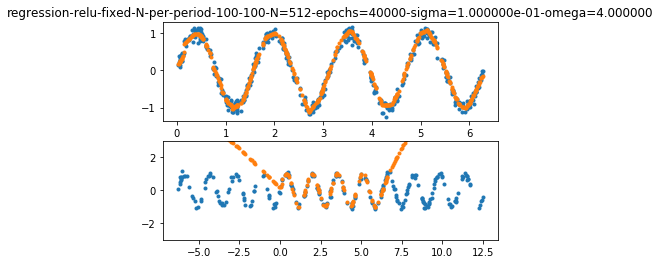

INFO:root:loss = 0.8373677244616446, global_step = 1, epochs = 1
INFO:root:loss = 0.4974070836235003, global_step = 477, epochs = 60 (1.055 sec)
INFO:root:loss = 0.5225923367514178, global_step = 1002, epochs = 126 (1.290 sec)
INFO:root:loss = 0.41167687285764787, global_step = 1581, epochs = 198 (1.007 sec)
INFO:root:loss = 0.3714005940361375, global_step = 1968, epochs = 246 (1.002 sec)
INFO:root:loss = 0.4401526561883518, global_step = 2084, epochs = 261 (1.003 sec)
INFO:root:loss = 0.470365113633454, global_step = 2496, epochs = 312 (1.006 sec)
INFO:root:loss = 0.38524189386062163, global_step = 2954, epochs = 370 (1.004 sec)
INFO:root:loss = 0.41380986221510085, global_step = 3155, epochs = 395 (1.003 sec)
INFO:root:loss = 0.35505437276805807, global_step = 3639, epochs = 455 (1.004 sec)
INFO:root:loss = 0.4087387466038463, global_step = 4002, epochs = 501 (1.026 sec)
INFO:root:loss = 0.41664616562319934, global_step = 4539, epochs = 568 (1.002 sec)
INFO:root:loss = 0.393894503859

INFO:root:loss = 0.19971905071878004, global_step = 46614, epochs = 5827 (1.002 sec)
INFO:root:loss = 0.19523034480500343, global_step = 47016, epochs = 5877 (1.002 sec)
INFO:root:loss = 0.20008382643276873, global_step = 47635, epochs = 5955 (1.002 sec)
INFO:root:loss = 0.20961180170886848, global_step = 48002, epochs = 6001 (1.003 sec)
INFO:root:loss = 0.2745216874396338, global_step = 48600, epochs = 6075 (1.003 sec)
INFO:root:loss = 0.1939475687011019, global_step = 49002, epochs = 6126 (1.081 sec)
INFO:root:loss = 0.28761649744823947, global_step = 49560, epochs = 6195 (1.002 sec)
INFO:root:loss = 0.1879117489954643, global_step = 50002, epochs = 6251 (1.170 sec)
INFO:root:loss = 0.18370854132237527, global_step = 50613, epochs = 6327 (1.002 sec)
INFO:root:loss = 0.1613615590316752, global_step = 51033, epochs = 6380 (1.003 sec)
INFO:root:loss = 0.16989994943927128, global_step = 51654, epochs = 6457 (1.002 sec)
INFO:root:loss = 0.21581695772775672, global_step = 52002, epochs = 6

INFO:root:loss = 0.10191983190118234, global_step = 93274, epochs = 11660 (1.003 sec)
INFO:root:loss = 0.09703574113044577, global_step = 93885, epochs = 11736 (1.003 sec)
INFO:root:loss = 0.1235481556797699, global_step = 94312, epochs = 11789 (1.002 sec)
INFO:root:loss = 0.1058843513450582, global_step = 94893, epochs = 11862 (1.003 sec)
INFO:root:loss = 0.13098226259126577, global_step = 95256, epochs = 11907 (1.003 sec)
INFO:root:loss = 0.09142328152482848, global_step = 95779, epochs = 11973 (1.003 sec)
INFO:root:loss = 0.1268426694992188, global_step = 96138, epochs = 12018 (1.004 sec)
INFO:root:loss = 0.12077600193021833, global_step = 96726, epochs = 12091 (1.001 sec)
INFO:root:loss = 0.13005819904475058, global_step = 97085, epochs = 12136 (1.002 sec)
INFO:root:loss = 0.08133701971978298, global_step = 97679, epochs = 12210 (1.002 sec)
INFO:root:loss = 0.0746166248363098, global_step = 98057, epochs = 12258 (1.003 sec)
INFO:root:loss = 0.10873749890530514, global_step = 98637,

INFO:root:loss = 0.02288758290177762, global_step = 137002, epochs = 17126 (1.269 sec)
INFO:root:loss = 0.01599438496018421, global_step = 137533, epochs = 17192 (1.002 sec)
INFO:root:loss = 0.023377643446162624, global_step = 138002, epochs = 17251 (1.220 sec)
INFO:root:loss = 0.01909385048800964, global_step = 138593, epochs = 17325 (1.004 sec)
INFO:root:loss = 0.020340731236757413, global_step = 139002, epochs = 17376 (1.052 sec)
INFO:root:loss = 0.01794464473354281, global_step = 139613, epochs = 17452 (1.001 sec)
INFO:root:loss = 0.018685200516273558, global_step = 140002, epochs = 17501 (1.079 sec)
INFO:root:loss = 0.021597317792356595, global_step = 140570, epochs = 17572 (1.003 sec)
INFO:root:loss = 0.02901164964037623, global_step = 141002, epochs = 17626 (1.067 sec)
INFO:root:loss = 0.018486118410628014, global_step = 141598, epochs = 17700 (1.002 sec)
INFO:root:loss = 0.016874260964539766, global_step = 142002, epochs = 17751 (1.210 sec)
INFO:root:loss = 0.021512882320152818

INFO:root:loss = 0.01057127248013921, global_step = 182002, epochs = 22751 (1.187 sec)
INFO:root:loss = 0.012975552034973172, global_step = 182580, epochs = 22823 (1.001 sec)
INFO:root:loss = 0.013857816684607777, global_step = 183002, epochs = 22876 (1.014 sec)
INFO:root:loss = 0.015672832082012426, global_step = 183590, epochs = 22949 (1.003 sec)
INFO:root:loss = 0.01238005809992536, global_step = 184002, epochs = 23001 (1.114 sec)
INFO:root:loss = 0.013189535904331539, global_step = 184605, epochs = 23076 (1.002 sec)
INFO:root:loss = 0.009844451535876736, global_step = 185002, epochs = 23126 (1.074 sec)
INFO:root:loss = 0.014588612909496389, global_step = 185541, epochs = 23193 (1.003 sec)
INFO:root:loss = 0.012057762611497453, global_step = 185893, epochs = 23237 (1.006 sec)
INFO:root:loss = 0.014175326208074317, global_step = 186098, epochs = 23263 (1.002 sec)
INFO:root:loss = 0.010283629720937871, global_step = 186564, epochs = 23321 (1.002 sec)
INFO:root:loss = 0.013729152167775

INFO:root:loss = 0.014058633996069533, global_step = 228002, epochs = 28501 (1.261 sec)
INFO:root:loss = 0.01612370399989526, global_step = 228505, epochs = 28564 (1.003 sec)
INFO:root:loss = 0.016569976769859104, global_step = 229002, epochs = 28626 (1.252 sec)
INFO:root:loss = 0.010356788420280719, global_step = 229570, epochs = 28697 (1.005 sec)
INFO:root:loss = 0.009674563163232876, global_step = 230002, epochs = 28751 (1.009 sec)
INFO:root:loss = 0.020332547832494396, global_step = 230642, epochs = 28831 (1.003 sec)
INFO:root:loss = 0.012318789057041904, global_step = 231024, epochs = 28878 (1.002 sec)
INFO:root:loss = 0.012296079849508713, global_step = 231640, epochs = 28955 (1.003 sec)
INFO:root:loss = 0.01732556955388839, global_step = 232004, epochs = 29001 (1.002 sec)
INFO:root:loss = 0.012811726037510143, global_step = 232643, epochs = 29081 (1.002 sec)
INFO:root:loss = 0.01170524908115514, global_step = 233046, epochs = 29131 (1.002 sec)
INFO:root:loss = 0.0170578464982631

INFO:root:loss = 0.018938007264177225, global_step = 273862, epochs = 34233 (1.003 sec)
INFO:root:loss = 0.013795769804256041, global_step = 274199, epochs = 34275 (1.003 sec)
INFO:root:loss = 0.014029064780127075, global_step = 274798, epochs = 34350 (1.002 sec)
INFO:root:loss = 0.011550791282075302, global_step = 275113, epochs = 34390 (1.003 sec)
INFO:root:loss = 0.012109702753482813, global_step = 275669, epochs = 34459 (1.002 sec)
INFO:root:loss = 0.012647607830894988, global_step = 276056, epochs = 34507 (1.002 sec)
INFO:root:loss = 0.016071937713394123, global_step = 276700, epochs = 34588 (1.002 sec)
INFO:root:loss = 0.01407424025978599, global_step = 277109, epochs = 34639 (1.002 sec)
INFO:root:loss = 0.0155322577064946, global_step = 277759, epochs = 34720 (1.003 sec)
INFO:root:loss = 0.021751720826214183, global_step = 278194, epochs = 34775 (1.003 sec)
INFO:root:loss = 0.011390783058126262, global_step = 278826, epochs = 34854 (1.003 sec)
INFO:root:loss = 0.0129072418464084

INFO:root:loss = 0.0124779633573219, global_step = 321738, epochs = 40218 (1.003 sec)
INFO:root:loss = 0.018436804729747708, global_step = 322122, epochs = 40266 (1.003 sec)
INFO:root:loss = 0.010384543723316365, global_step = 322767, epochs = 40346 (1.002 sec)
INFO:root:loss = 0.017207392920859026, global_step = 323181, epochs = 40398 (1.002 sec)
INFO:root:loss = 0.010882303198914037, global_step = 323806, epochs = 40476 (1.001 sec)
INFO:root:loss = 0.015877860765635864, global_step = 324206, epochs = 40526 (1.002 sec)
INFO:root:loss = 0.026519057074021902, global_step = 324850, epochs = 40607 (1.002 sec)
INFO:root:loss = 0.01390346667733892, global_step = 325217, epochs = 40653 (1.003 sec)
INFO:root:loss = 0.00871277121966141, global_step = 325859, epochs = 40733 (1.003 sec)
INFO:root:loss = 0.010157003647990433, global_step = 326282, epochs = 40786 (1.002 sec)
INFO:root:loss = 0.012150987937671973, global_step = 326914, epochs = 40865 (1.002 sec)
INFO:root:loss = 0.01819399156759786

INFO:root:loss = 0.018225186467402087, global_step = 367046, epochs = 45881 (1.003 sec)
INFO:root:loss = 0.012344291435320332, global_step = 367678, epochs = 45960 (1.002 sec)
INFO:root:loss = 0.012220356440979414, global_step = 368100, epochs = 46013 (1.002 sec)
INFO:root:loss = 0.011694420959150607, global_step = 368752, epochs = 46094 (1.002 sec)
INFO:root:loss = 0.012050559748463342, global_step = 369151, epochs = 46144 (1.002 sec)
INFO:root:loss = 0.014701897076753212, global_step = 369800, epochs = 46225 (1.003 sec)
INFO:root:loss = 0.017263326771844847, global_step = 370210, epochs = 46277 (1.003 sec)
INFO:root:loss = 0.014685536758917025, global_step = 370861, epochs = 46358 (1.004 sec)
INFO:root:loss = 0.015341732897738554, global_step = 371252, epochs = 46407 (1.002 sec)
INFO:root:loss = 0.012773496435797088, global_step = 371856, epochs = 46482 (1.003 sec)
INFO:root:loss = 0.012077543008376589, global_step = 372314, epochs = 46540 (1.002 sec)
INFO:root:loss = 0.0118687782366

INFO:root:loss = 0.011814789408304193, global_step = 413043, epochs = 51631 (1.004 sec)
INFO:root:loss = 0.012149898654543417, global_step = 413691, epochs = 51712 (1.002 sec)
INFO:root:loss = 0.011738030751604591, global_step = 414090, epochs = 51762 (1.003 sec)
INFO:root:loss = 0.018122660595427977, global_step = 414717, epochs = 51840 (1.003 sec)
INFO:root:loss = 0.01590197513258531, global_step = 415127, epochs = 51891 (1.003 sec)
INFO:root:loss = 0.010236333558295552, global_step = 415730, epochs = 51967 (1.003 sec)
INFO:root:loss = 0.010989034355893955, global_step = 416142, epochs = 52018 (1.002 sec)
INFO:root:loss = 0.011380632200644036, global_step = 416778, epochs = 52098 (1.003 sec)
INFO:root:loss = 0.012710560223919677, global_step = 417162, epochs = 52146 (1.003 sec)
INFO:root:loss = 0.019241006648600366, global_step = 417718, epochs = 52215 (1.002 sec)
INFO:root:loss = 0.014622956020496574, global_step = 418151, epochs = 52269 (1.002 sec)
INFO:root:loss = 0.01168854080091

INFO:root:loss = 0.0155373250059155, global_step = 460049, epochs = 57507 (1.003 sec)
INFO:root:loss = 0.012943358194662897, global_step = 460568, epochs = 57571 (1.002 sec)
INFO:root:loss = 0.010625622145028137, global_step = 461002, epochs = 57626 (1.154 sec)
INFO:root:loss = 0.012269156877089769, global_step = 461591, epochs = 57699 (1.003 sec)
INFO:root:loss = 0.010186010386123732, global_step = 462009, epochs = 57752 (1.002 sec)
INFO:root:loss = 0.014038542950544342, global_step = 462615, epochs = 57827 (1.004 sec)
INFO:root:loss = 0.011846108158665757, global_step = 463002, epochs = 57876 (1.021 sec)
INFO:root:loss = 0.010439918166053443, global_step = 463527, epochs = 57941 (1.003 sec)
INFO:root:loss = 0.012595741025660946, global_step = 464002, epochs = 58001 (1.125 sec)
INFO:root:loss = 0.008847673115350438, global_step = 464498, epochs = 58063 (1.003 sec)
INFO:root:loss = 0.012641145443104698, global_step = 465002, epochs = 58126 (1.185 sec)
INFO:root:loss = 0.011598094495216

INFO:root:loss = 0.010525376544200655, global_step = 506159, epochs = 63270 (1.003 sec)
INFO:root:loss = 0.01251225089456797, global_step = 506777, epochs = 63348 (1.003 sec)
INFO:root:loss = 0.01252393201717545, global_step = 507165, epochs = 63396 (1.002 sec)
INFO:root:loss = 0.013436642849324606, global_step = 507786, epochs = 63474 (1.003 sec)
INFO:root:loss = 0.012110810141536373, global_step = 508174, epochs = 63522 (1.002 sec)
INFO:root:loss = 0.011467997480602154, global_step = 508712, epochs = 63589 (1.003 sec)
INFO:root:loss = 0.009382186248480539, global_step = 509002, epochs = 63626 (1.123 sec)
INFO:root:loss = 0.01100848206398438, global_step = 509513, epochs = 63690 (1.003 sec)
INFO:root:loss = 0.011633202220940591, global_step = 510002, epochs = 63751 (1.210 sec)
INFO:root:loss = 0.011665305189447337, global_step = 510574, epochs = 63822 (1.001 sec)
INFO:root:loss = 0.011719531247903255, global_step = 511002, epochs = 63876 (1.098 sec)
INFO:root:loss = 0.0125431333410063

INFO:root:loss = 0.011478014581522448, global_step = 553002, epochs = 69126 (1.038 sec)
INFO:root:loss = 0.009512004513548042, global_step = 553619, epochs = 69203 (1.002 sec)
INFO:root:loss = 0.011291164037217968, global_step = 554002, epochs = 69251 (1.024 sec)
INFO:root:loss = 0.011962761539654192, global_step = 554586, epochs = 69324 (1.003 sec)
INFO:root:loss = 0.01657341134469945, global_step = 555002, epochs = 69376 (1.039 sec)
INFO:root:loss = 0.015289717686403534, global_step = 555643, epochs = 69456 (1.002 sec)
INFO:root:loss = 0.009281357848267646, global_step = 556002, epochs = 69501 (1.065 sec)
INFO:root:loss = 0.012137813138341672, global_step = 556630, epochs = 69579 (1.002 sec)
INFO:root:loss = 0.014065762817509542, global_step = 557067, epochs = 69634 (1.002 sec)
INFO:root:loss = 0.012652207867810829, global_step = 557660, epochs = 69708 (1.002 sec)
INFO:root:loss = 0.019542272480544468, global_step = 558034, epochs = 69755 (1.003 sec)
INFO:root:loss = 0.01172008926709

INFO:root:loss = 0.01636300919344126, global_step = 597648, epochs = 74706 (1.002 sec)
INFO:root:loss = 0.014017241455004395, global_step = 598002, epochs = 74751 (1.016 sec)
INFO:root:loss = 0.012567665525732453, global_step = 598515, epochs = 74815 (1.002 sec)
INFO:root:loss = 0.012487813253998106, global_step = 599002, epochs = 74876 (1.260 sec)
INFO:root:loss = 0.011895580964437158, global_step = 599586, epochs = 74949 (1.002 sec)
INFO:root:loss = 0.01544201457280093, global_step = 600013, epochs = 75002 (1.002 sec)
INFO:root:loss = 0.01264691750466318, global_step = 600635, epochs = 75080 (1.002 sec)
INFO:root:loss = 0.01090901039637885, global_step = 601002, epochs = 75126 (1.204 sec)
INFO:root:loss = 0.010794674144428196, global_step = 601435, epochs = 75180 (1.005 sec)
INFO:root:loss = 0.007662613554204459, global_step = 601833, epochs = 75230 (1.003 sec)
INFO:root:loss = 0.009263549376315777, global_step = 602169, epochs = 75272 (1.003 sec)
INFO:root:loss = 0.0163215669575405,

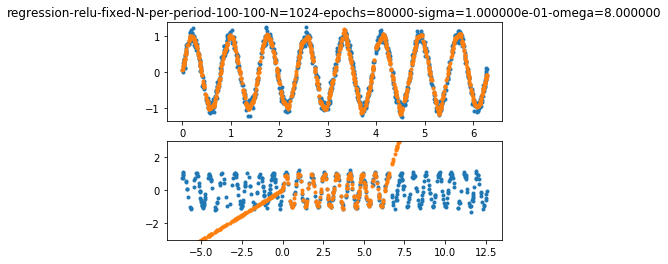

INFO:root:loss = 0.5138581946087757, global_step = 1, epochs = 1
INFO:root:loss = 0.4191505071108888, global_step = 536, epochs = 34 (1.035 sec)
INFO:root:loss = 0.472483160863049, global_step = 1002, epochs = 63 (1.233 sec)
INFO:root:loss = 0.47689044144874615, global_step = 1630, epochs = 102 (1.001 sec)
INFO:root:loss = 0.44318152512474274, global_step = 2061, epochs = 129 (1.004 sec)
INFO:root:loss = 0.5060848873203182, global_step = 2716, epochs = 170 (1.002 sec)
INFO:root:loss = 0.48019136925187456, global_step = 3139, epochs = 197 (1.003 sec)
INFO:root:loss = 0.5261199474173586, global_step = 3810, epochs = 239 (1.005 sec)
INFO:root:loss = 0.46449907122299805, global_step = 4224, epochs = 264 (1.002 sec)
INFO:root:loss = 0.4719171162617082, global_step = 4882, epochs = 306 (1.005 sec)
INFO:root:loss = 0.4906341339293602, global_step = 5329, epochs = 334 (1.004 sec)
INFO:root:loss = 0.39810690988880404, global_step = 5975, epochs = 374 (1.003 sec)
INFO:root:loss = 0.4420331337966

INFO:root:loss = 0.34211349931729285, global_step = 50002, epochs = 3126 (1.087 sec)
INFO:root:loss = 0.32441086399215957, global_step = 50380, epochs = 3149 (1.005 sec)
INFO:root:loss = 0.40609115003698415, global_step = 50792, epochs = 3175 (1.005 sec)
INFO:root:loss = 0.30021836500047866, global_step = 51021, epochs = 3189 (1.002 sec)
INFO:root:loss = 0.37560263236648084, global_step = 51556, epochs = 3223 (1.004 sec)
INFO:root:loss = 0.35237792802153994, global_step = 52002, epochs = 3251 (1.408 sec)
INFO:root:loss = 0.3581483272530582, global_step = 52480, epochs = 3280 (1.003 sec)
INFO:root:loss = 0.42214576805005477, global_step = 52954, epochs = 3310 (1.003 sec)
INFO:root:loss = 0.3476142098501932, global_step = 53202, epochs = 3326 (1.004 sec)
INFO:root:loss = 0.36524120434823704, global_step = 53760, epochs = 3360 (1.003 sec)
INFO:root:loss = 0.37639307916845965, global_step = 54111, epochs = 3382 (1.003 sec)
INFO:root:loss = 0.3855285683409355, global_step = 54654, epochs = 

INFO:root:loss = 0.40429293386750553, global_step = 97002, epochs = 6063 (1.262 sec)
INFO:root:loss = 0.33497080856271705, global_step = 97522, epochs = 6096 (1.004 sec)
INFO:root:loss = 0.3922687519899546, global_step = 98002, epochs = 6126 (1.395 sec)
INFO:root:loss = 0.37277214862145247, global_step = 98552, epochs = 6160 (1.003 sec)
INFO:root:loss = 0.3641499323451364, global_step = 99002, epochs = 6188 (1.161 sec)
INFO:root:loss = 0.3586706467279385, global_step = 99557, epochs = 6223 (1.003 sec)
INFO:root:loss = 0.31540505404407393, global_step = 100002, epochs = 6251 (1.292 sec)
INFO:root:loss = 0.33215051841758536, global_step = 100563, epochs = 6286 (1.002 sec)
INFO:root:loss = 0.3442033204088186, global_step = 101002, epochs = 6313 (1.160 sec)
INFO:root:loss = 0.376939983527655, global_step = 101607, epochs = 6351 (1.002 sec)
INFO:root:loss = 0.37969742500824927, global_step = 102018, epochs = 6377 (1.006 sec)
INFO:root:loss = 0.30885457101941605, global_step = 102495, epochs

INFO:root:loss = 0.3980556136711567, global_step = 140604, epochs = 8788 (1.002 sec)
INFO:root:loss = 0.3239519180188247, global_step = 141002, epochs = 8813 (1.121 sec)
INFO:root:loss = 0.3423200603537963, global_step = 141521, epochs = 8846 (1.004 sec)
INFO:root:loss = 0.39777870394792003, global_step = 142002, epochs = 8876 (1.251 sec)
INFO:root:loss = 0.3140811647603061, global_step = 142568, epochs = 8911 (1.003 sec)
INFO:root:loss = 0.3838294919536367, global_step = 143002, epochs = 8938 (1.158 sec)
INFO:root:loss = 0.3493538374092694, global_step = 143564, epochs = 8973 (1.003 sec)
INFO:root:loss = 0.3734495020092346, global_step = 144002, epochs = 9001 (1.147 sec)
INFO:root:loss = 0.34279962210692794, global_step = 144577, epochs = 9037 (1.004 sec)
INFO:root:loss = 0.36514172708979753, global_step = 145002, epochs = 9063 (1.201 sec)
INFO:root:loss = 0.37199321265225915, global_step = 145616, epochs = 9101 (1.002 sec)
INFO:root:loss = 0.33711992566868626, global_step = 146002, e

INFO:root:loss = 0.30821559255461106, global_step = 185495, epochs = 11594 (1.002 sec)
INFO:root:loss = 0.3588391751817316, global_step = 185981, epochs = 11624 (1.004 sec)
INFO:root:loss = 0.33198077196245873, global_step = 186295, epochs = 11644 (1.004 sec)
INFO:root:loss = 0.32824436064400087, global_step = 186863, epochs = 11679 (1.003 sec)
INFO:root:loss = 0.36564917165462907, global_step = 187131, epochs = 11696 (1.005 sec)
INFO:root:loss = 0.26027671590311685, global_step = 187630, epochs = 11727 (1.004 sec)
INFO:root:loss = 0.2683980336595415, global_step = 188002, epochs = 11751 (1.128 sec)
INFO:root:loss = 0.292122206393121, global_step = 188520, epochs = 11783 (1.005 sec)
INFO:root:loss = 0.2943851741451993, global_step = 189002, epochs = 11813 (1.235 sec)
INFO:root:loss = 0.29953896211294156, global_step = 189532, epochs = 11846 (1.002 sec)
INFO:root:loss = 0.2857738832653177, global_step = 190002, epochs = 11876 (1.305 sec)
INFO:root:loss = 0.257553738937296, global_step =

INFO:root:loss = 0.2897040204016358, global_step = 226571, epochs = 14161 (1.002 sec)
INFO:root:loss = 0.27825765555999377, global_step = 227002, epochs = 14188 (1.357 sec)
INFO:root:loss = 0.27359788783580163, global_step = 227575, epochs = 14224 (1.003 sec)
INFO:root:loss = 0.19713778101858953, global_step = 228002, epochs = 14251 (1.111 sec)
INFO:root:loss = 0.2695706527985001, global_step = 228501, epochs = 14282 (1.005 sec)
INFO:root:loss = 0.26315060284821523, global_step = 228883, epochs = 14306 (1.007 sec)
INFO:root:loss = 0.2630193402837321, global_step = 229095, epochs = 14319 (1.002 sec)
INFO:root:loss = 0.3287770770353501, global_step = 229619, epochs = 14352 (1.005 sec)
INFO:root:loss = 0.3357485460278953, global_step = 230002, epochs = 14376 (1.261 sec)
INFO:root:loss = 0.35714772472838296, global_step = 230539, epochs = 14409 (1.004 sec)
INFO:root:loss = 0.256707719394073, global_step = 231002, epochs = 14438 (1.260 sec)
INFO:root:loss = 0.22009947357360182, global_step 

INFO:root:loss = 0.2964221843011928, global_step = 269002, epochs = 16813 (1.083 sec)
INFO:root:loss = 0.2616734099648672, global_step = 269577, epochs = 16849 (1.002 sec)
INFO:root:loss = 0.2587175694673425, global_step = 270002, epochs = 16876 (1.147 sec)
INFO:root:loss = 0.32147634202053926, global_step = 270579, epochs = 16912 (1.002 sec)
INFO:root:loss = 0.29426903186812847, global_step = 271002, epochs = 16938 (1.043 sec)
INFO:root:loss = 0.24624565946351212, global_step = 271573, epochs = 16974 (1.003 sec)
INFO:root:loss = 0.3035770171004667, global_step = 272002, epochs = 17001 (1.161 sec)
INFO:root:loss = 0.23408137717624844, global_step = 272514, epochs = 17033 (1.002 sec)
INFO:root:loss = 0.2703860252211338, global_step = 272898, epochs = 17057 (1.003 sec)
INFO:root:loss = 0.29344268061876255, global_step = 273101, epochs = 17069 (1.003 sec)
INFO:root:loss = 0.3040245668180798, global_step = 273527, epochs = 17096 (1.002 sec)
INFO:root:loss = 0.3171764142101203, global_step 

INFO:root:loss = 0.3087960431784564, global_step = 313600, epochs = 19600 (1.003 sec)
INFO:root:loss = 0.29244679985677946, global_step = 314002, epochs = 19626 (1.006 sec)
INFO:root:loss = 0.2890867336401523, global_step = 314538, epochs = 19659 (1.003 sec)
INFO:root:loss = 0.2903799305580088, global_step = 315002, epochs = 19688 (1.185 sec)
INFO:root:loss = 0.2874941336963711, global_step = 315513, epochs = 19720 (1.003 sec)
INFO:root:loss = 0.25943639445804145, global_step = 316002, epochs = 19751 (1.419 sec)
INFO:root:loss = 0.27336151890513055, global_step = 316594, epochs = 19788 (1.004 sec)
INFO:root:loss = 0.2789269336199049, global_step = 317002, epochs = 19813 (1.019 sec)
INFO:root:loss = 0.2992590200216611, global_step = 317554, epochs = 19848 (1.003 sec)
INFO:root:loss = 0.2973897087622033, global_step = 318002, epochs = 19876 (1.236 sec)
INFO:root:loss = 0.3209008593222714, global_step = 318599, epochs = 19913 (1.002 sec)
INFO:root:loss = 0.2721765136547135, global_step = 

INFO:root:loss = 0.31173325757632353, global_step = 359770, epochs = 22486 (1.002 sec)
INFO:root:loss = 0.30010971970234285, global_step = 360122, epochs = 22508 (1.003 sec)
INFO:root:loss = 0.29166016145750717, global_step = 360662, epochs = 22542 (1.005 sec)
INFO:root:loss = 0.2867692804654103, global_step = 361006, epochs = 22563 (1.002 sec)
INFO:root:loss = 0.28489759739901127, global_step = 361574, epochs = 22599 (1.003 sec)
INFO:root:loss = 0.35816666934348373, global_step = 362002, epochs = 22626 (1.208 sec)
INFO:root:loss = 0.2997895516605238, global_step = 362592, epochs = 22662 (1.002 sec)
INFO:root:loss = 0.34784335715185666, global_step = 363002, epochs = 22688 (1.088 sec)
INFO:root:loss = 0.3249780096192878, global_step = 363607, epochs = 22726 (1.002 sec)
INFO:root:loss = 0.31752790189370256, global_step = 364017, epochs = 22752 (1.004 sec)
INFO:root:loss = 0.2983902287213132, global_step = 364626, epochs = 22790 (1.004 sec)
INFO:root:loss = 0.2755615097054568, global_ste

INFO:root:loss = 0.2901465868097888, global_step = 404023, epochs = 25252 (1.002 sec)
INFO:root:loss = 0.2666697780325682, global_step = 404629, epochs = 25290 (1.003 sec)
INFO:root:loss = 0.30391833962802306, global_step = 405034, epochs = 25315 (1.002 sec)
INFO:root:loss = 0.30878198569310356, global_step = 405673, epochs = 25355 (1.003 sec)
INFO:root:loss = 0.29063041727066996, global_step = 406057, epochs = 25379 (1.002 sec)
INFO:root:loss = 0.2744279855585617, global_step = 406552, epochs = 25410 (1.005 sec)
INFO:root:loss = 0.3007707541603653, global_step = 407002, epochs = 25438 (1.154 sec)
INFO:root:loss = 0.28517688113131634, global_step = 407560, epochs = 25473 (1.004 sec)
INFO:root:loss = 0.3029137435654353, global_step = 408002, epochs = 25501 (1.215 sec)
INFO:root:loss = 0.34836427388656155, global_step = 408603, epochs = 25538 (1.003 sec)
INFO:root:loss = 0.3117632199285046, global_step = 409002, epochs = 25563 (1.075 sec)
INFO:root:loss = 0.281760568653498, global_step =

INFO:root:loss = 0.30983353994481333, global_step = 448800, epochs = 28050 (1.003 sec)
INFO:root:loss = 0.30756759685902146, global_step = 449168, epochs = 28073 (1.003 sec)
INFO:root:loss = 0.31054622670762616, global_step = 449663, epochs = 28104 (1.003 sec)
INFO:root:loss = 0.3458709112111975, global_step = 450002, epochs = 28126 (1.034 sec)
INFO:root:loss = 0.2957853040257051, global_step = 450506, epochs = 28157 (1.002 sec)
INFO:root:loss = 0.2944146019350134, global_step = 450878, epochs = 28180 (1.004 sec)
INFO:root:loss = 0.2733590682338775, global_step = 451202, epochs = 28201 (1.007 sec)
INFO:root:loss = 0.26500324358321603, global_step = 451758, epochs = 28235 (1.003 sec)
INFO:root:loss = 0.28759333779447804, global_step = 452127, epochs = 28258 (1.002 sec)
INFO:root:loss = 0.3213457520203165, global_step = 452614, epochs = 28289 (1.002 sec)
INFO:root:loss = 0.32085951173756233, global_step = 453002, epochs = 28313 (1.016 sec)
INFO:root:loss = 0.30967517074152484, global_ste

INFO:root:loss = 0.257445806720325, global_step = 492578, epochs = 30787 (1.011 sec)
INFO:root:loss = 0.3129318501319771, global_step = 493002, epochs = 30813 (1.239 sec)
INFO:root:loss = 0.2644791944031094, global_step = 493499, epochs = 30844 (1.008 sec)
INFO:root:loss = 0.27767189079961946, global_step = 494002, epochs = 30876 (1.339 sec)
INFO:root:loss = 0.28827851535111093, global_step = 494488, epochs = 30906 (1.002 sec)
INFO:root:loss = 0.34549455644252614, global_step = 495002, epochs = 30938 (1.344 sec)
INFO:root:loss = 0.2938832992886596, global_step = 495557, epochs = 30973 (1.003 sec)
INFO:root:loss = 0.22345854737610313, global_step = 496002, epochs = 31001 (1.572 sec)
INFO:root:loss = 0.35320326097086935, global_step = 496508, epochs = 31032 (1.002 sec)
INFO:root:loss = 0.34403540302911106, global_step = 496955, epochs = 31060 (1.002 sec)
INFO:root:loss = 0.2835179113361688, global_step = 497219, epochs = 31077 (1.002 sec)
INFO:root:loss = 0.23951905606824164, global_step

INFO:root:loss = 0.3645190591116964, global_step = 535002, epochs = 33438 (1.059 sec)
INFO:root:loss = 0.24014450642937454, global_step = 535612, epochs = 33476 (1.001 sec)
INFO:root:loss = 0.2349301102709901, global_step = 536031, epochs = 33502 (1.002 sec)
INFO:root:loss = 0.28660076332767676, global_step = 536509, epochs = 33532 (1.007 sec)
INFO:root:loss = 0.2971492644725774, global_step = 537002, epochs = 33563 (1.382 sec)
INFO:root:loss = 0.24067544035420596, global_step = 537523, epochs = 33596 (1.002 sec)
INFO:root:loss = 0.31989993358552116, global_step = 538002, epochs = 33626 (1.234 sec)
INFO:root:loss = 0.31463005442000896, global_step = 538599, epochs = 33663 (1.004 sec)
INFO:root:loss = 0.3141277866708525, global_step = 539002, epochs = 33688 (1.076 sec)
INFO:root:loss = 0.3277996870414174, global_step = 539579, epochs = 33724 (1.002 sec)
INFO:root:loss = 0.3800462611472929, global_step = 540002, epochs = 33751 (1.026 sec)
INFO:root:loss = 0.30508962883070867, global_step

INFO:root:loss = 0.25230793520369627, global_step = 576002, epochs = 36001 (1.001 sec)
INFO:root:loss = 0.31011402963148327, global_step = 576598, epochs = 36038 (1.003 sec)
INFO:root:loss = 0.353270038587421, global_step = 577002, epochs = 36063 (1.079 sec)
INFO:root:loss = 0.2626639993655596, global_step = 577615, epochs = 36101 (1.002 sec)
INFO:root:loss = 0.2897461972866433, global_step = 578002, epochs = 36126 (1.023 sec)
INFO:root:loss = 0.28071187060080816, global_step = 578526, epochs = 36158 (1.003 sec)
INFO:root:loss = 0.30174000416542474, global_step = 578975, epochs = 36186 (1.001 sec)
INFO:root:loss = 0.27134711612421003, global_step = 579283, epochs = 36206 (1.002 sec)
INFO:root:loss = 0.2683825156345243, global_step = 579811, epochs = 36239 (1.004 sec)
INFO:root:loss = 0.29615890974523873, global_step = 580133, epochs = 36259 (1.003 sec)
INFO:root:loss = 0.287950150765408, global_step = 580685, epochs = 36293 (1.003 sec)
INFO:root:loss = 0.3042497273449962, global_step =

INFO:root:loss = 0.3314824517686587, global_step = 619358, epochs = 38710 (1.002 sec)
INFO:root:loss = 0.25319783615897645, global_step = 619871, epochs = 38742 (1.002 sec)
INFO:root:loss = 0.28791300109722207, global_step = 620175, epochs = 38761 (1.002 sec)
INFO:root:loss = 0.29707137159270547, global_step = 620741, epochs = 38797 (1.001 sec)
INFO:root:loss = 0.35837099202250094, global_step = 621019, epochs = 38814 (1.003 sec)
INFO:root:loss = 0.28685261018170377, global_step = 621481, epochs = 38843 (1.003 sec)
INFO:root:loss = 0.3298732495794042, global_step = 621960, epochs = 38873 (1.005 sec)
INFO:root:loss = 0.3030113208644477, global_step = 622220, epochs = 38889 (1.004 sec)
INFO:root:loss = 0.2784669750794928, global_step = 622786, epochs = 38925 (1.003 sec)
INFO:root:loss = 0.3012918396638711, global_step = 623129, epochs = 38946 (1.002 sec)
INFO:root:loss = 0.2928108882989097, global_step = 623650, epochs = 38979 (1.002 sec)
INFO:root:loss = 0.28182063766591686, global_step

INFO:root:loss = 0.2615676120133861, global_step = 664978, epochs = 41562 (1.003 sec)
INFO:root:loss = 0.27338962219369756, global_step = 665363, epochs = 41586 (1.002 sec)
INFO:root:loss = 0.23381017118374853, global_step = 665983, epochs = 41624 (1.002 sec)
INFO:root:loss = 0.2549490347036685, global_step = 666390, epochs = 41650 (1.002 sec)
INFO:root:loss = 0.2713717663849533, global_step = 667002, epochs = 41688 (1.354 sec)
INFO:root:loss = 0.404277502896096, global_step = 667628, epochs = 41727 (1.002 sec)
INFO:root:loss = 0.3377693094220514, global_step = 668020, epochs = 41752 (1.002 sec)
INFO:root:loss = 0.28572897852896534, global_step = 668626, epochs = 41790 (1.005 sec)
INFO:root:loss = 0.3063086464742388, global_step = 669044, epochs = 41816 (1.002 sec)
INFO:root:loss = 0.30934146259430034, global_step = 669619, epochs = 41852 (1.003 sec)
INFO:root:loss = 0.21853181112932482, global_step = 670002, epochs = 41876 (1.006 sec)
INFO:root:loss = 0.2786468234919678, global_step =

INFO:root:loss = 0.345102814961732, global_step = 707002, epochs = 44188 (1.154 sec)
INFO:root:loss = 0.2536991984227907, global_step = 707609, epochs = 44226 (1.001 sec)
INFO:root:loss = 0.34017596646672416, global_step = 708005, epochs = 44251 (1.003 sec)
INFO:root:loss = 0.2592827561106922, global_step = 708583, epochs = 44287 (1.002 sec)
INFO:root:loss = 0.2709617667340479, global_step = 709002, epochs = 44313 (1.061 sec)
INFO:root:loss = 0.31847734569725306, global_step = 709594, epochs = 44350 (1.001 sec)
INFO:root:loss = 0.23034542107291178, global_step = 710002, epochs = 44376 (1.138 sec)
INFO:root:loss = 0.2711041541269703, global_step = 710542, epochs = 44409 (1.006 sec)
INFO:root:loss = 0.2987337151756752, global_step = 710937, epochs = 44434 (1.002 sec)
INFO:root:loss = 0.2829765536108623, global_step = 711243, epochs = 44453 (1.003 sec)
INFO:root:loss = 0.27444933296852014, global_step = 711808, epochs = 44488 (1.002 sec)
INFO:root:loss = 0.28921282201081167, global_step =

INFO:root:loss = 0.2631202587275232, global_step = 753651, epochs = 47104 (1.003 sec)
INFO:root:loss = 0.2872146521498663, global_step = 754002, epochs = 47126 (1.148 sec)
INFO:root:loss = 0.25386619365384083, global_step = 754442, epochs = 47153 (1.002 sec)
INFO:root:loss = 0.2756601324708057, global_step = 754865, epochs = 47180 (1.004 sec)
INFO:root:loss = 0.254721918493189, global_step = 755201, epochs = 47201 (1.006 sec)
INFO:root:loss = 0.2838274164198555, global_step = 755757, epochs = 47235 (1.002 sec)
INFO:root:loss = 0.2958147784636417, global_step = 756074, epochs = 47255 (1.004 sec)
INFO:root:loss = 0.2615545307916935, global_step = 756529, epochs = 47284 (1.007 sec)
INFO:root:loss = 0.3144093956702749, global_step = 757002, epochs = 47313 (1.425 sec)
INFO:root:loss = 0.33596414982695044, global_step = 757566, epochs = 47348 (1.003 sec)
INFO:root:loss = 0.27068300021688, global_step = 758002, epochs = 47376 (1.058 sec)
INFO:root:loss = 0.2707833271709518, global_step = 7585

INFO:root:loss = 0.29732264014974213, global_step = 799002, epochs = 49938 (1.054 sec)
INFO:root:loss = 0.2690821315289297, global_step = 799603, epochs = 49976 (1.002 sec)
INFO:root:loss = 0.26431512270126295, global_step = 800002, epochs = 50001 (1.095 sec)
INFO:root:loss = 0.3382172178588114, global_step = 800542, epochs = 50034 (1.023 sec)
INFO:root:loss = 0.3126948994167732, global_step = 800936, epochs = 50059 (1.003 sec)
INFO:root:loss = 0.3107909625288672, global_step = 801291, epochs = 50081 (1.004 sec)
INFO:root:loss = 0.305260025700012, global_step = 801832, epochs = 50115 (1.002 sec)
INFO:root:loss = 0.2998145712224328, global_step = 802158, epochs = 50135 (1.002 sec)
INFO:root:loss = 0.3728432036460157, global_step = 802707, epochs = 50170 (1.003 sec)
INFO:root:loss = 0.3483536126910755, global_step = 803002, epochs = 50188 (1.038 sec)
INFO:root:loss = 0.23287685700862099, global_step = 803548, epochs = 50222 (1.002 sec)
INFO:root:loss = 0.2821274478243877, global_step = 8

INFO:root:loss = 0.23432870075292217, global_step = 842226, epochs = 52640 (1.004 sec)
INFO:root:loss = 0.2654555709602633, global_step = 842659, epochs = 52667 (1.004 sec)
INFO:root:loss = 0.291371340741847, global_step = 843002, epochs = 52688 (1.080 sec)
INFO:root:loss = 0.28459143510040236, global_step = 843586, epochs = 52725 (1.004 sec)
INFO:root:loss = 0.2895616286103235, global_step = 844005, epochs = 52751 (1.003 sec)
INFO:root:loss = 0.32760546838207316, global_step = 844553, epochs = 52785 (1.002 sec)
INFO:root:loss = 0.2832426228028938, global_step = 845002, epochs = 52813 (1.144 sec)
INFO:root:loss = 0.28238814875727786, global_step = 845572, epochs = 52849 (1.003 sec)
INFO:root:loss = 0.2606295968593961, global_step = 846002, epochs = 52876 (1.085 sec)
INFO:root:loss = 0.3145260964263062, global_step = 846616, epochs = 52914 (1.002 sec)
INFO:root:loss = 0.25237716305883257, global_step = 847002, epochs = 52938 (1.108 sec)
INFO:root:loss = 0.3063969206407554, global_step =

INFO:root:loss = 0.33836667183736024, global_step = 887002, epochs = 55438 (1.389 sec)
INFO:root:loss = 0.2887286257801702, global_step = 887375, epochs = 55461 (1.005 sec)
INFO:root:loss = 0.2627625006356063, global_step = 887816, epochs = 55489 (1.002 sec)
INFO:root:loss = 0.3204738603506937, global_step = 888237, epochs = 55515 (1.002 sec)
INFO:root:loss = 0.2599524489476417, global_step = 888774, epochs = 55549 (1.003 sec)
INFO:root:loss = 0.2573083480562597, global_step = 889146, epochs = 55572 (1.001 sec)
INFO:root:loss = 0.25462671983550217, global_step = 889707, epochs = 55607 (1.008 sec)
INFO:root:loss = 0.252424803280788, global_step = 890056, epochs = 55629 (1.002 sec)
INFO:root:loss = 0.3104293187375894, global_step = 890546, epochs = 55660 (1.003 sec)
INFO:root:loss = 0.2746279947732738, global_step = 891002, epochs = 55688 (1.103 sec)
INFO:root:loss = 0.2959511822735459, global_step = 891554, epochs = 55723 (1.002 sec)
INFO:root:loss = 0.30179288776788527, global_step = 8

INFO:root:loss = 0.32376980344348827, global_step = 930788, epochs = 58175 (1.002 sec)
INFO:root:loss = 0.3459648589305409, global_step = 931234, epochs = 58203 (1.003 sec)
INFO:root:loss = 0.28329861955114916, global_step = 931837, epochs = 58240 (1.004 sec)
INFO:root:loss = 0.2676515515650118, global_step = 932223, epochs = 58264 (1.003 sec)
INFO:root:loss = 0.27859067393434245, global_step = 932850, epochs = 58304 (1.003 sec)
INFO:root:loss = 0.27726420750455816, global_step = 933240, epochs = 58328 (1.002 sec)
INFO:root:loss = 0.30173602308341796, global_step = 933859, epochs = 58367 (1.002 sec)
INFO:root:loss = 0.2889365215657638, global_step = 934080, epochs = 58380 (1.004 sec)
INFO:root:loss = 0.3013766849810462, global_step = 934510, epochs = 58407 (1.002 sec)
INFO:root:loss = 0.25807354794032433, global_step = 934941, epochs = 58434 (1.003 sec)
INFO:root:loss = 0.2899059325086461, global_step = 935287, epochs = 58456 (1.002 sec)
INFO:root:loss = 0.21425820582098914, global_ste

INFO:root:loss = 0.2991117103630496, global_step = 975600, epochs = 60975 (1.002 sec)
INFO:root:loss = 0.2285307186100078, global_step = 976002, epochs = 61001 (1.114 sec)
INFO:root:loss = 0.25787796315981915, global_step = 976606, epochs = 61038 (1.003 sec)
INFO:root:loss = 0.35660556797178333, global_step = 977002, epochs = 61063 (1.131 sec)
INFO:root:loss = 0.3622840735717867, global_step = 977523, epochs = 61096 (1.002 sec)
INFO:root:loss = 0.2761111848523541, global_step = 978002, epochs = 61126 (1.137 sec)
INFO:root:loss = 0.26614826166244254, global_step = 978578, epochs = 61162 (1.002 sec)
INFO:root:loss = 0.28412203001313774, global_step = 979002, epochs = 61188 (1.402 sec)
INFO:root:loss = 0.29561261722404175, global_step = 979581, epochs = 61224 (1.002 sec)
INFO:root:loss = 0.27611898089789133, global_step = 980002, epochs = 61251 (1.073 sec)
INFO:root:loss = 0.28793937031203476, global_step = 980610, epochs = 61289 (1.002 sec)
INFO:root:loss = 0.3255418095853738, global_ste

INFO:root:loss = 0.33025907900173923, global_step = 1020240, epochs = 63765 (1.002 sec)
INFO:root:loss = 0.29162236715967566, global_step = 1020877, epochs = 63805 (1.002 sec)
INFO:root:loss = 0.2577618075527871, global_step = 1021274, epochs = 63830 (1.002 sec)
INFO:root:loss = 0.25216409632411396, global_step = 1021888, epochs = 63868 (1.002 sec)
INFO:root:loss = 0.3091495812435105, global_step = 1022285, epochs = 63893 (1.002 sec)
INFO:root:loss = 0.30259307958199133, global_step = 1022767, epochs = 63923 (1.002 sec)
INFO:root:loss = 0.2622036158259995, global_step = 1023209, epochs = 63951 (1.002 sec)
INFO:root:loss = 0.3285658739731005, global_step = 1023777, epochs = 63987 (1.004 sec)
INFO:root:loss = 0.326200400950837, global_step = 1024173, epochs = 64011 (1.002 sec)
INFO:root:loss = 0.2485158302721897, global_step = 1024821, epochs = 64052 (1.002 sec)
INFO:root:loss = 0.3107290696313525, global_step = 1025245, epochs = 64078 (1.002 sec)
INFO:root:loss = 0.298623613389346, glob

INFO:root:loss = 0.2780986874417576, global_step = 1064631, epochs = 66540 (1.003 sec)
INFO:root:loss = 0.2695856217338588, global_step = 1065023, epochs = 66564 (1.002 sec)
INFO:root:loss = 0.2844130435861917, global_step = 1065651, epochs = 66604 (1.002 sec)
INFO:root:loss = 0.31031805571893506, global_step = 1066006, epochs = 66626 (1.003 sec)
INFO:root:loss = 0.3241761836700875, global_step = 1066620, epochs = 66664 (1.004 sec)
INFO:root:loss = 0.24359812484504323, global_step = 1067035, epochs = 66690 (1.002 sec)
INFO:root:loss = 0.2918471282559567, global_step = 1067654, epochs = 66729 (1.003 sec)
INFO:root:loss = 0.3376776653573108, global_step = 1068049, epochs = 66754 (1.004 sec)
INFO:root:loss = 0.24455049693386838, global_step = 1068690, epochs = 66794 (1.005 sec)
INFO:root:loss = 0.27871152677575173, global_step = 1069096, epochs = 66819 (1.002 sec)
INFO:root:loss = 0.2838801089811157, global_step = 1069638, epochs = 66853 (1.002 sec)
INFO:root:loss = 0.29909443412064196, g

INFO:root:loss = 0.2922990647325614, global_step = 1110002, epochs = 69376 (1.339 sec)
INFO:root:loss = 0.26109177866879, global_step = 1110537, epochs = 69409 (1.001 sec)
INFO:root:loss = 0.28611750579129014, global_step = 1111002, epochs = 69438 (1.167 sec)
INFO:root:loss = 0.3361029040354529, global_step = 1111635, epochs = 69478 (1.002 sec)
INFO:root:loss = 0.2612544172730089, global_step = 1112025, epochs = 69502 (1.003 sec)
INFO:root:loss = 0.27928726532798986, global_step = 1112667, epochs = 69542 (1.002 sec)
INFO:root:loss = 0.25218877723888966, global_step = 1113038, epochs = 69565 (1.002 sec)
INFO:root:loss = 0.27130082459873495, global_step = 1113611, epochs = 69601 (1.002 sec)
INFO:root:loss = 0.2859056996991628, global_step = 1113994, epochs = 69625 (1.005 sec)
INFO:root:loss = 0.34815518075192686, global_step = 1114186, epochs = 69637 (1.003 sec)
INFO:root:loss = 0.2418797666676522, global_step = 1114585, epochs = 69662 (1.003 sec)
INFO:root:loss = 0.3145590943874494, glo

INFO:root:loss = 0.2337774187249005, global_step = 1153245, epochs = 72078 (1.003 sec)
INFO:root:loss = 0.28590670675074314, global_step = 1153866, epochs = 72117 (1.002 sec)
INFO:root:loss = 0.3211477972121498, global_step = 1154140, epochs = 72134 (1.007 sec)
INFO:root:loss = 0.32613257619198444, global_step = 1154627, epochs = 72165 (1.002 sec)
INFO:root:loss = 0.2766390246322099, global_step = 1155002, epochs = 72188 (1.376 sec)
INFO:root:loss = 0.3052285205118481, global_step = 1155600, epochs = 72225 (1.002 sec)
INFO:root:loss = 0.29735878859831866, global_step = 1156002, epochs = 72251 (1.118 sec)
INFO:root:loss = 0.23514346036900002, global_step = 1156574, epochs = 72286 (1.002 sec)
INFO:root:loss = 0.3117027642450285, global_step = 1157002, epochs = 72313 (1.095 sec)
INFO:root:loss = 0.3307876541619149, global_step = 1157556, epochs = 72348 (1.003 sec)
INFO:root:loss = 0.3071712348349304, global_step = 1157962, epochs = 72373 (1.003 sec)
INFO:root:loss = 0.3206664363063618, gl

INFO:root:loss = 0.3334741979653152, global_step = 1199404, epochs = 74963 (1.014 sec)
INFO:root:loss = 0.2578524845047987, global_step = 1199785, epochs = 74987 (1.003 sec)
INFO:root:loss = 0.25300799159316834, global_step = 1200088, epochs = 75006 (1.002 sec)
INFO:root:loss = 0.2654341993366117, global_step = 1200639, epochs = 75040 (1.002 sec)
INFO:root:loss = 0.35901273315283944, global_step = 1201022, epochs = 75064 (1.003 sec)
INFO:root:loss = 0.29317320571252475, global_step = 1201618, epochs = 75102 (1.004 sec)
INFO:root:loss = 0.3149721552614919, global_step = 1202002, epochs = 75126 (1.074 sec)
INFO:root:loss = 0.31956322360715383, global_step = 1202600, epochs = 75163 (1.002 sec)
INFO:root:loss = 0.28422490042650017, global_step = 1203028, epochs = 75190 (1.003 sec)
INFO:root:loss = 0.27608223658040587, global_step = 1203668, epochs = 75230 (1.002 sec)
INFO:root:loss = 0.3034557745429549, global_step = 1204050, epochs = 75254 (1.004 sec)
INFO:root:loss = 0.3114370884900817, 

INFO:root:loss = 0.3256928323173778, global_step = 1243862, epochs = 77742 (1.002 sec)
INFO:root:loss = 0.3013793565381515, global_step = 1244120, epochs = 77758 (1.003 sec)
INFO:root:loss = 0.2881346835632044, global_step = 1244574, epochs = 77786 (1.002 sec)
INFO:root:loss = 0.2929017752608393, global_step = 1245002, epochs = 77813 (1.184 sec)
INFO:root:loss = 0.2521909760580777, global_step = 1245587, epochs = 77850 (1.003 sec)
INFO:root:loss = 0.2541603070924639, global_step = 1246002, epochs = 77876 (1.256 sec)
INFO:root:loss = 0.27553241875532036, global_step = 1246478, epochs = 77905 (1.004 sec)
INFO:root:loss = 0.26236099759386333, global_step = 1246972, epochs = 77936 (1.002 sec)
INFO:root:loss = 0.39476682999672963, global_step = 1247274, epochs = 77955 (1.002 sec)
INFO:root:loss = 0.2684824828459531, global_step = 1247798, epochs = 77988 (1.002 sec)
INFO:root:loss = 0.3237714854879259, global_step = 1248052, epochs = 78004 (1.002 sec)
INFO:root:loss = 0.2854244818153858, glo

INFO:root:loss = 0.27666961196129625, global_step = 1288825, epochs = 80552 (1.003 sec)
INFO:root:loss = 0.2955783890431989, global_step = 1289246, epochs = 80578 (1.003 sec)
INFO:root:loss = 0.24493131972079282, global_step = 1289844, epochs = 80616 (1.002 sec)
INFO:root:loss = 0.283361297725102, global_step = 1290235, epochs = 80640 (1.003 sec)
INFO:root:loss = 0.3166958885985295, global_step = 1290833, epochs = 80678 (1.005 sec)
INFO:root:loss = 0.31567490547276805, global_step = 1291046, epochs = 80691 (1.003 sec)
INFO:root:loss = 0.32868718588011714, global_step = 1291576, epochs = 80724 (1.003 sec)
INFO:root:loss = 0.24891970537268582, global_step = 1292002, epochs = 80751 (1.015 sec)
INFO:root:loss = 0.27161718227018683, global_step = 1292604, epochs = 80788 (1.002 sec)
INFO:root:loss = 0.22714118363292596, global_step = 1293002, epochs = 80813 (1.092 sec)
INFO:root:loss = 0.3330207528318291, global_step = 1293569, epochs = 80849 (1.004 sec)
INFO:root:loss = 0.3171739708664141, 

INFO:root:loss = 0.27448486030768343, global_step = 1334631, epochs = 83415 (1.003 sec)
INFO:root:loss = 0.3144172302486401, global_step = 1335055, epochs = 83441 (1.003 sec)
INFO:root:loss = 0.29392685249773254, global_step = 1335688, epochs = 83481 (1.004 sec)
INFO:root:loss = 0.31507903745034155, global_step = 1336074, epochs = 83505 (1.003 sec)
INFO:root:loss = 0.29212701670736413, global_step = 1336713, epochs = 83545 (1.002 sec)
INFO:root:loss = 0.26564941719451113, global_step = 1337108, epochs = 83570 (1.003 sec)
INFO:root:loss = 0.2612614160732455, global_step = 1337739, epochs = 83609 (1.005 sec)
INFO:root:loss = 0.25957325018374594, global_step = 1338101, epochs = 83632 (1.003 sec)
INFO:root:loss = 0.3213448774385473, global_step = 1338670, epochs = 83667 (1.002 sec)
INFO:root:loss = 0.31506837996765136, global_step = 1339094, epochs = 83694 (1.003 sec)
INFO:root:loss = 0.29322263867181, global_step = 1339731, epochs = 83734 (1.002 sec)
INFO:root:loss = 0.3220673343965287, g

INFO:root:loss = 0.23908070938669163, global_step = 1379961, epochs = 86248 (1.002 sec)
INFO:root:loss = 0.25261352844523854, global_step = 1380210, epochs = 86264 (1.007 sec)
INFO:root:loss = 0.3407359563938651, global_step = 1380652, epochs = 86291 (1.006 sec)
INFO:root:loss = 0.3071508365792375, global_step = 1381002, epochs = 86313 (1.139 sec)
INFO:root:loss = 0.2491903620539019, global_step = 1381385, epochs = 86337 (1.003 sec)
INFO:root:loss = 0.2557096984972983, global_step = 1381795, epochs = 86363 (1.002 sec)
INFO:root:loss = 0.2833888319147768, global_step = 1382058, epochs = 86379 (1.003 sec)
INFO:root:loss = 0.29450455262535646, global_step = 1382538, epochs = 86409 (1.004 sec)
INFO:root:loss = 0.31357680771741336, global_step = 1383002, epochs = 86438 (1.357 sec)
INFO:root:loss = 0.34871487481772767, global_step = 1383588, epochs = 86475 (1.023 sec)
INFO:root:loss = 0.2943316378190086, global_step = 1384002, epochs = 86501 (1.195 sec)
INFO:root:loss = 0.27902498901675216, 

INFO:root:loss = 0.2524729545418751, global_step = 1425002, epochs = 89063 (1.163 sec)
INFO:root:loss = 0.34470653326319683, global_step = 1425467, epochs = 89092 (1.003 sec)
INFO:root:loss = 0.29632471775714186, global_step = 1426002, epochs = 89126 (1.289 sec)
INFO:root:loss = 0.29610394185920647, global_step = 1426528, epochs = 89158 (1.002 sec)
INFO:root:loss = 0.2861807107419011, global_step = 1427002, epochs = 89188 (1.264 sec)
INFO:root:loss = 0.32325565538249584, global_step = 1427620, epochs = 89227 (1.002 sec)
INFO:root:loss = 0.3129542144618258, global_step = 1428004, epochs = 89251 (1.002 sec)
INFO:root:loss = 0.24335983750173612, global_step = 1428634, epochs = 89290 (1.001 sec)
INFO:root:loss = 0.2921301425857288, global_step = 1429077, epochs = 89318 (1.004 sec)
INFO:root:loss = 0.2958892798666244, global_step = 1429700, epochs = 89357 (1.003 sec)
INFO:root:loss = 0.31221841764691133, global_step = 1430098, epochs = 89382 (1.002 sec)
INFO:root:loss = 0.2517142208673162, 

INFO:root:loss = 0.2896671288762064, global_step = 1472706, epochs = 92045 (1.004 sec)
INFO:root:loss = 0.37105172668786285, global_step = 1473138, epochs = 92072 (1.004 sec)
INFO:root:loss = 0.27648498516755715, global_step = 1473778, epochs = 92112 (1.004 sec)
INFO:root:loss = 0.30006866153094325, global_step = 1474175, epochs = 92136 (1.001 sec)
INFO:root:loss = 0.3052512431956855, global_step = 1474819, epochs = 92177 (1.005 sec)
INFO:root:loss = 0.308354511979189, global_step = 1475214, epochs = 92201 (1.006 sec)
INFO:root:loss = 0.30187916008946636, global_step = 1475756, epochs = 92235 (1.002 sec)
INFO:root:loss = 0.24923827821032427, global_step = 1476176, epochs = 92261 (1.003 sec)
INFO:root:loss = 0.26631283394596605, global_step = 1476819, epochs = 92302 (1.003 sec)
INFO:root:loss = 0.2724986166645893, global_step = 1477218, epochs = 92327 (1.005 sec)
INFO:root:loss = 0.3131992563588725, global_step = 1477821, epochs = 92364 (1.002 sec)
INFO:root:loss = 0.2762355632851498, g

INFO:root:loss = 0.2689473541312931, global_step = 1519847, epochs = 94991 (1.003 sec)
INFO:root:loss = 0.2819196768196951, global_step = 1520273, epochs = 95018 (1.004 sec)
INFO:root:loss = 0.24897582249146444, global_step = 1520873, epochs = 95055 (1.002 sec)
INFO:root:loss = 0.2531582522356104, global_step = 1521244, epochs = 95078 (1.002 sec)
INFO:root:loss = 0.2650371533247103, global_step = 1521825, epochs = 95115 (1.005 sec)
INFO:root:loss = 0.3067700216481667, global_step = 1522168, epochs = 95136 (1.002 sec)
INFO:root:loss = 0.26470192650742935, global_step = 1522795, epochs = 95175 (1.002 sec)
INFO:root:loss = 0.28594955045209847, global_step = 1523201, epochs = 95201 (1.004 sec)
INFO:root:loss = 0.27352126301024937, global_step = 1523802, epochs = 95238 (1.003 sec)
INFO:root:loss = 0.3067490222406145, global_step = 1524253, epochs = 95266 (1.002 sec)
INFO:root:loss = 0.3401858868869764, global_step = 1524873, epochs = 95305 (1.002 sec)
INFO:root:loss = 0.23849160724127355, g

INFO:root:loss = 0.27536884178049226, global_step = 1566604, epochs = 97913 (1.003 sec)
INFO:root:loss = 0.24849810679830642, global_step = 1567041, epochs = 97941 (1.003 sec)
INFO:root:loss = 0.29642432075910163, global_step = 1567680, epochs = 97980 (1.003 sec)
INFO:root:loss = 0.2426879893172522, global_step = 1568089, epochs = 98006 (1.002 sec)
INFO:root:loss = 0.28169792570040114, global_step = 1568728, epochs = 98046 (1.003 sec)
INFO:root:loss = 0.31239761375448727, global_step = 1569112, epochs = 98070 (1.001 sec)
INFO:root:loss = 0.28842917962228953, global_step = 1569743, epochs = 98109 (1.004 sec)
INFO:root:loss = 0.2742460995130185, global_step = 1570120, epochs = 98133 (1.003 sec)
INFO:root:loss = 0.27029414961694403, global_step = 1570686, epochs = 98168 (1.004 sec)
INFO:root:loss = 0.3297042689263739, global_step = 1571085, epochs = 98193 (1.004 sec)
INFO:root:loss = 0.32853266164202144, global_step = 1571646, epochs = 98228 (1.003 sec)
INFO:root:loss = 0.2850902353729113

INFO:root:loss = 0.30736371804868334, global_step = 1613100, epochs = 100819 (1.004 sec)
INFO:root:loss = 0.3084226634486251, global_step = 1613709, epochs = 100857 (1.002 sec)
INFO:root:loss = 0.2247127704658678, global_step = 1614033, epochs = 100878 (1.005 sec)
INFO:root:loss = 0.2871760883716261, global_step = 1614603, epochs = 100913 (1.002 sec)
INFO:root:loss = 0.31109749261488107, global_step = 1615006, epochs = 100938 (1.003 sec)
INFO:root:loss = 0.3076681365873273, global_step = 1615562, epochs = 100973 (1.002 sec)
INFO:root:loss = 0.3502211627528276, global_step = 1616002, epochs = 101001 (1.226 sec)
INFO:root:loss = 0.25015726255742476, global_step = 1616619, epochs = 101039 (1.002 sec)
INFO:root:loss = 0.2938279966848039, global_step = 1617002, epochs = 101063 (1.171 sec)
INFO:root:loss = 0.3005412157175852, global_step = 1617418, epochs = 101089 (1.009 sec)
INFO:root:loss = 0.3345137126490264, global_step = 1617839, epochs = 101115 (1.003 sec)
INFO:root:loss = 0.2834463717

INFO:root:loss = 0.22164932123337489, global_step = 1659619, epochs = 103727 (1.002 sec)
INFO:root:loss = 0.27431816070519444, global_step = 1660002, epochs = 103751 (1.127 sec)
INFO:root:loss = 0.27354700721689806, global_step = 1660570, epochs = 103786 (1.003 sec)
INFO:root:loss = 0.27083763768251956, global_step = 1661002, epochs = 103813 (1.157 sec)
INFO:root:loss = 0.29513968555417613, global_step = 1661586, epochs = 103850 (1.004 sec)
INFO:root:loss = 0.2813709723898977, global_step = 1662002, epochs = 103876 (1.078 sec)
INFO:root:loss = 0.3244654345582233, global_step = 1662637, epochs = 103915 (1.004 sec)
INFO:root:loss = 0.29182784967830855, global_step = 1663038, epochs = 103940 (1.002 sec)
INFO:root:loss = 0.3202572287188763, global_step = 1663670, epochs = 103980 (1.002 sec)
INFO:root:loss = 0.3104095024695811, global_step = 1664107, epochs = 104007 (1.004 sec)
INFO:root:loss = 0.2561925285050666, global_step = 1664712, epochs = 104045 (1.003 sec)
INFO:root:loss = 0.2937901

INFO:root:loss = 0.3411985128483201, global_step = 1705626, epochs = 106602 (1.003 sec)
INFO:root:loss = 0.23882389368356904, global_step = 1706064, epochs = 106629 (1.002 sec)
INFO:root:loss = 0.28834608064022244, global_step = 1706667, epochs = 106667 (1.002 sec)
INFO:root:loss = 0.2417860049707865, global_step = 1707057, epochs = 106692 (1.005 sec)
INFO:root:loss = 0.28391736987827965, global_step = 1707628, epochs = 106727 (1.002 sec)
INFO:root:loss = 0.2973593037709287, global_step = 1708011, epochs = 106751 (1.002 sec)
INFO:root:loss = 0.2926034377605615, global_step = 1708660, epochs = 106792 (1.003 sec)
INFO:root:loss = 0.35194548500285305, global_step = 1709050, epochs = 106816 (1.001 sec)
INFO:root:loss = 0.29751153946973674, global_step = 1709678, epochs = 106855 (1.003 sec)
INFO:root:loss = 0.2950149459027308, global_step = 1710121, epochs = 106883 (1.002 sec)
INFO:root:loss = 0.3214236935782596, global_step = 1710766, epochs = 106923 (1.003 sec)
INFO:root:loss = 0.26528720

INFO:root:loss = 0.28856689055257045, global_step = 1751281, epochs = 109456 (1.004 sec)
INFO:root:loss = 0.2815013528868354, global_step = 1751910, epochs = 109495 (1.003 sec)
INFO:root:loss = 0.3119679469897623, global_step = 1752322, epochs = 109521 (1.002 sec)
INFO:root:loss = 0.2613730784126351, global_step = 1752954, epochs = 109560 (1.003 sec)
INFO:root:loss = 0.28813050532554607, global_step = 1753361, epochs = 109586 (1.004 sec)
INFO:root:loss = 0.2769517009776026, global_step = 1753913, epochs = 109620 (1.005 sec)
INFO:root:loss = 0.31891878443155786, global_step = 1754321, epochs = 109646 (1.003 sec)
INFO:root:loss = 0.23502698964385504, global_step = 1754953, epochs = 109685 (1.002 sec)
INFO:root:loss = 0.2635457386237646, global_step = 1755366, epochs = 109711 (1.002 sec)
INFO:root:loss = 0.31584681922790003, global_step = 1755971, epochs = 109749 (1.003 sec)
INFO:root:loss = 0.27789119221779646, global_step = 1756353, epochs = 109773 (1.004 sec)
INFO:root:loss = 0.3022115

INFO:root:loss = 0.3196727307179979, global_step = 1798695, epochs = 112419 (1.001 sec)
INFO:root:loss = 0.2755459793747955, global_step = 1799090, epochs = 112444 (1.002 sec)
INFO:root:loss = 0.33148056301393536, global_step = 1799605, epochs = 112476 (1.002 sec)
INFO:root:loss = 0.3170634357784511, global_step = 1800002, epochs = 112501 (1.040 sec)
INFO:root:loss = 0.27611717164775873, global_step = 1800646, epochs = 112541 (1.001 sec)
INFO:root:loss = 0.30748943710733423, global_step = 1801040, epochs = 112565 (1.002 sec)
INFO:root:loss = 0.33131724746335217, global_step = 1801682, epochs = 112606 (1.005 sec)
INFO:root:loss = 0.2908415054640786, global_step = 1802126, epochs = 112633 (1.002 sec)
INFO:root:loss = 0.2684451361515886, global_step = 1802762, epochs = 112673 (1.002 sec)
INFO:root:loss = 0.30827460392327993, global_step = 1803129, epochs = 112696 (1.004 sec)
INFO:root:loss = 0.30012299607588255, global_step = 1803751, epochs = 112735 (1.003 sec)
INFO:root:loss = 0.2628935

INFO:root:loss = 0.25586881422089225, global_step = 1841667, epochs = 115105 (1.002 sec)
INFO:root:loss = 0.2587952499751296, global_step = 1842078, epochs = 115130 (1.003 sec)
INFO:root:loss = 0.342126652547196, global_step = 1842699, epochs = 115169 (1.001 sec)
INFO:root:loss = 0.2724338594016019, global_step = 1843030, epochs = 115190 (1.003 sec)
INFO:root:loss = 0.31992937608533645, global_step = 1843482, epochs = 115218 (1.003 sec)
INFO:root:loss = 0.2570065534712277, global_step = 1843997, epochs = 115250 (1.003 sec)
INFO:root:loss = 0.3037316823419255, global_step = 1844385, epochs = 115275 (1.004 sec)
INFO:root:loss = 0.30882218643261306, global_step = 1845002, epochs = 115313 (1.316 sec)
INFO:root:loss = 0.33934356830602064, global_step = 1845616, epochs = 115351 (1.002 sec)
INFO:root:loss = 0.2705274387137546, global_step = 1846029, epochs = 115377 (1.002 sec)
INFO:root:loss = 0.276927764689335, global_step = 1846631, epochs = 115415 (1.002 sec)
INFO:root:loss = 0.31328397776

INFO:root:loss = 0.3020939748379833, global_step = 1886002, epochs = 117876 (1.292 sec)
INFO:root:loss = 0.2658651304177393, global_step = 1886502, epochs = 117907 (1.003 sec)
INFO:root:loss = 0.25768350265561274, global_step = 1886926, epochs = 117933 (1.002 sec)
INFO:root:loss = 0.3428940375822237, global_step = 1887252, epochs = 117954 (1.002 sec)
INFO:root:loss = 0.26865438721254775, global_step = 1887882, epochs = 117993 (1.002 sec)
INFO:root:loss = 0.24344464560416892, global_step = 1888249, epochs = 118016 (1.001 sec)
INFO:root:loss = 0.33242070501368925, global_step = 1888823, epochs = 118052 (1.002 sec)
INFO:root:loss = 0.27633928642588956, global_step = 1889226, epochs = 118077 (1.003 sec)
INFO:root:loss = 0.31413381814675967, global_step = 1889721, epochs = 118108 (1.005 sec)
INFO:root:loss = 0.2769570795508758, global_step = 1890109, epochs = 118132 (1.001 sec)
INFO:root:loss = 0.28777159338322256, global_step = 1890764, epochs = 118173 (1.002 sec)
INFO:root:loss = 0.343038

INFO:root:loss = 0.29317355261014566, global_step = 1931002, epochs = 120688 (1.040 sec)
INFO:root:loss = 0.3327796113295142, global_step = 1931549, epochs = 120722 (1.002 sec)
INFO:root:loss = 0.3558842482355471, global_step = 1932002, epochs = 120751 (1.235 sec)
INFO:root:loss = 0.29044166699970003, global_step = 1932630, epochs = 120790 (1.002 sec)
INFO:root:loss = 0.3034616725836182, global_step = 1933002, epochs = 120813 (1.007 sec)
INFO:root:loss = 0.2444695552039208, global_step = 1933666, epochs = 120855 (1.002 sec)
INFO:root:loss = 0.26401871489563516, global_step = 1934084, epochs = 120881 (1.001 sec)
INFO:root:loss = 0.3094497119811839, global_step = 1934661, epochs = 120917 (1.002 sec)
INFO:root:loss = 0.30078085199497107, global_step = 1935033, epochs = 120940 (1.004 sec)
INFO:root:loss = 0.347640156295958, global_step = 1935602, epochs = 120976 (1.005 sec)
INFO:root:loss = 0.3539841591485168, global_step = 1936014, epochs = 121001 (1.002 sec)
INFO:root:loss = 0.2448061131

INFO:root:loss = 0.31461655926402715, global_step = 1980197, epochs = 123763 (1.002 sec)
INFO:root:loss = 0.3079656791511697, global_step = 1980866, epochs = 123805 (1.003 sec)
INFO:root:loss = 0.3234175937438166, global_step = 1981302, epochs = 123832 (1.004 sec)
INFO:root:loss = 0.2728633795541454, global_step = 1981944, epochs = 123872 (1.001 sec)
INFO:root:loss = 0.27623246883302127, global_step = 1982368, epochs = 123898 (1.002 sec)
INFO:root:loss = 0.3297876857650584, global_step = 1982997, epochs = 123938 (1.001 sec)
INFO:root:loss = 0.2911399076588699, global_step = 1983464, epochs = 123967 (1.003 sec)
INFO:root:loss = 0.3169817074669583, global_step = 1984002, epochs = 124001 (1.168 sec)
INFO:root:loss = 0.3068990372163927, global_step = 1984667, epochs = 124042 (1.002 sec)
INFO:root:loss = 0.3575293634919866, global_step = 1985076, epochs = 124068 (1.002 sec)
INFO:root:loss = 0.3716298775619205, global_step = 1985746, epochs = 124110 (1.002 sec)
INFO:root:loss = 0.30860449722

INFO:root:loss = 0.3817112004697628, global_step = 2027650, epochs = 126729 (1.001 sec)
INFO:root:loss = 0.3144674336327181, global_step = 2028066, epochs = 126755 (1.001 sec)
INFO:root:loss = 0.24741857697442354, global_step = 2028717, epochs = 126795 (1.003 sec)
INFO:root:loss = 0.30019414166493374, global_step = 2029091, epochs = 126819 (1.003 sec)
INFO:root:loss = 0.36082374382253857, global_step = 2029742, epochs = 126859 (1.003 sec)
INFO:root:loss = 0.27187036047006374, global_step = 2030178, epochs = 126887 (1.003 sec)
INFO:root:loss = 0.30597317477133357, global_step = 2030827, epochs = 126927 (1.002 sec)
INFO:root:loss = 0.2417323331429464, global_step = 2031246, epochs = 126953 (1.002 sec)
INFO:root:loss = 0.3087347547171687, global_step = 2031893, epochs = 126994 (1.001 sec)
INFO:root:loss = 0.277058781901944, global_step = 2032316, epochs = 127020 (1.002 sec)
INFO:root:loss = 0.301678989958603, global_step = 2032955, epochs = 127060 (1.004 sec)
INFO:root:loss = 0.3362103514

INFO:root:loss = 0.36157227895556404, global_step = 2073040, epochs = 129565 (1.002 sec)
INFO:root:loss = 0.27224640436843905, global_step = 2073602, epochs = 129601 (1.004 sec)
INFO:root:loss = 0.26614088319298107, global_step = 2074002, epochs = 129626 (1.064 sec)
INFO:root:loss = 0.2984016270048081, global_step = 2074586, epochs = 129662 (1.002 sec)
INFO:root:loss = 0.27997776431252985, global_step = 2075002, epochs = 129688 (1.052 sec)
INFO:root:loss = 0.30583823263206633, global_step = 2075594, epochs = 129725 (1.002 sec)
INFO:root:loss = 0.29131281225319194, global_step = 2076002, epochs = 129751 (1.053 sec)
INFO:root:loss = 0.30345023755738065, global_step = 2076630, epochs = 129790 (1.002 sec)
INFO:root:loss = 0.25363521408939965, global_step = 2077010, epochs = 129814 (1.002 sec)
INFO:root:loss = 0.27482428846588425, global_step = 2077567, epochs = 129848 (1.002 sec)
INFO:root:loss = 0.30843595259778805, global_step = 2078002, epochs = 129876 (1.081 sec)
INFO:root:loss = 0.282

INFO:root:loss = 0.28746586886943115, global_step = 2119572, epochs = 132474 (1.005 sec)
INFO:root:loss = 0.31883275485366414, global_step = 2120002, epochs = 132501 (1.187 sec)
INFO:root:loss = 0.27826145885478276, global_step = 2120627, epochs = 132540 (1.002 sec)
INFO:root:loss = 0.3167813089021398, global_step = 2121006, epochs = 132563 (1.002 sec)
INFO:root:loss = 0.3320330926023791, global_step = 2121527, epochs = 132596 (1.003 sec)
INFO:root:loss = 0.3561664713815568, global_step = 2122002, epochs = 132626 (1.231 sec)
INFO:root:loss = 0.2434870504766819, global_step = 2122458, epochs = 132654 (1.004 sec)
INFO:root:loss = 0.23613031372243998, global_step = 2123002, epochs = 132688 (1.286 sec)
INFO:root:loss = 0.32326033118572295, global_step = 2123443, epochs = 132716 (1.002 sec)
INFO:root:loss = 0.2995531627314262, global_step = 2124002, epochs = 132751 (1.292 sec)
INFO:root:loss = 0.27984265659088847, global_step = 2124609, epochs = 132789 (1.006 sec)
INFO:root:loss = 0.3189654

INFO:root:loss = 0.2719737921449836, global_step = 2163053, epochs = 135191 (1.002 sec)
INFO:root:loss = 0.2868376707524553, global_step = 2163704, epochs = 135232 (1.002 sec)
INFO:root:loss = 0.26366411881577934, global_step = 2164129, epochs = 135259 (1.004 sec)
INFO:root:loss = 0.2668360700279251, global_step = 2164788, epochs = 135300 (1.001 sec)
INFO:root:loss = 0.2795391427808449, global_step = 2165098, epochs = 135319 (1.003 sec)
INFO:root:loss = 0.2982272016818918, global_step = 2165726, epochs = 135358 (1.002 sec)
INFO:root:loss = 0.27804451581379336, global_step = 2166146, epochs = 135385 (1.002 sec)
INFO:root:loss = 0.23122924536628403, global_step = 2166809, epochs = 135426 (1.003 sec)
INFO:root:loss = 0.297139110979975, global_step = 2167263, epochs = 135454 (1.003 sec)
INFO:root:loss = 0.2818016644693243, global_step = 2167913, epochs = 135495 (1.002 sec)
INFO:root:loss = 0.30800468432371786, global_step = 2168331, epochs = 135521 (1.003 sec)
INFO:root:loss = 0.3040647699

In [ ]:
# TODO rewrite using ExperimentParams

from deep_regression import *

model_name = 'regression-relu-fixed-N-per-period'
model_fn = model_fn_relu

widths = [100, 100]
# epochs = 20000
learning_rate = 1e-3
batch_size = 128

# n_val = 128
n_train_per_period = 128

noise_sigma = 0.1

xmin = 0.
xmax = 2. * math.pi

omegas = [1.0, 2.0, 3.0, 4.0, 8.0, 16.0]

for idx, omega in enumerate(omegas):

    n_train = int(n_train_per_period*omega)
    n_val = int(n_train/2)
    epochs = int(10000*omega)

    model = create_estimator(model_fn, widths, n_train, learning_rate,
                             noise_sigma, model_name, omega)
    target_fn = create_target_fn(noise_sigma, omega)
        
    # Train
    train_x, train_y = train(model, target_fn, n_train, epochs, batch_size)
    
    # Evaluate
    train_input_fn = create_input_fn_from_data(train_x, train_y, shuffle=False)
    train_pred = predict(model, train_input_fn)

    test_input_fn, test_x, test_y = create_input_fn(
        target_fn, xmin - 2*math.pi, xmax + 2*math.pi, n_val, epochs=1, batch_size=batch_size, shuffle=False)
    test_pred = predict(model, test_input_fn)

    plt.figure(idx)
    plt.clf()
    
    widths_str = '-'.join([str(w) for w in widths])
    noise_str = 'sigma=%e' % noise_sigma
    omega_str = 'omega=%f' % omega
    epochs_str = 'epochs=%d' % epochs
    plot_str = '%s-%s-N=%d-%s-%s-%s' % (
        model_name, widths_str, n_train, epochs_str, noise_str, omega_str
    )
    
    plt.subplot(211)
    plt.plot(train_x, train_y, '.', train_x, train_pred, '.')
#     plt.title('%s layers=%s N=%d epochs=%d' % (model_name, widths, n_train, epochs))
    plt.title(plot_str)

    plt.subplot(212)
    plt.plot(test_x, test_y, '.', test_x, test_pred, '.')
    plt.ylim(-3,3)
    
    plt.savefig('plot-%s.png' % plot_str)
    plt.show()
